In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
import numpy as np
import matplotlib.pyplot as plt

2025-01-17 06:42:28.262319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 06:42:30.469329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Ensure TensorFlow uses all CPUs
tf.config.threading.set_intra_op_parallelism_threads(40)
tf.config.threading.set_inter_op_parallelism_threads(40)

In [3]:
data_files = ["../data0.npy", "../data1.npy", "../data2.npy"]
label_files = ["../lab0.npy", "../lab1.npy", "../lab2.npy"]

combined_data = []
combined_labels = []

for data_file, label_file in zip(data_files, label_files):
    data = np.load(data_file)
    labels = np.load(label_file)
    combined_data.append(data)
    combined_labels.append(labels)

train_data = np.concatenate(combined_data, axis=0)
train_labels = np.concatenate(combined_labels, axis=0)

train_data = train_data[..., np.newaxis]

In [4]:
train_data = train_data.astype('float32') / 255.0

print("Combined data shape:", train_data.shape)
print("Combined labels shape:", train_labels.shape)

# Reshape labels for regression
train_labels = train_labels.reshape(-1, 1)

Combined data shape: (30000, 40, 168, 1)
Combined labels shape: (30000,)


In [5]:
train_data_resized = tf.image.resize(train_data, (224, 224)).numpy()

print("Resized train data shape:", train_data_resized.shape)

2025-01-17 06:43:11.370694: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Resized train data shape: (30000, 224, 224, 1)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_data_resized, train_labels, test_size=0.2, random_state=42)

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Train data shape: (24000, 224, 224, 1)
Validation data shape: (6000, 224, 224, 1)


In [8]:
# Create the model
base_model = MobileNetV2(
    input_shape=(224, 224, 3), 
    include_top=False,
    weights='imagenet'
)

In [9]:
inputs = layers.Input(shape=(224, 224, 1))  # Grayscale input
x = layers.Conv2D(3, (1, 1))(inputs)  # Convert grayscale to 3 channels
x = base_model(x, training=False)  # Freeze base model
x = layers.GlobalAveragePooling2D()(x)  # Pool the features
x = layers.Dense(128, activation="relu")(x)  # Add a dense layer
outputs = layers.Dense(1)(x)  # Single output for regression
model = models.Model(inputs, outputs)

In [10]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']  # Mean Absolute Error
)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,087 (9.24 MB)

 Trainable params: 2,387,975 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
# Create tf.data datasets
batch_size = 32
train_dataset_new = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset_new = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Optimize dataset pipeline
train_dataset_new = (
    train_dataset_new
    .shuffle(buffer_size=1000)  # Shuffle data for randomness
    .batch(batch_size)
)
val_dataset_new = (
    val_dataset_new
    .batch(batch_size)
)

In [13]:
history = model.fit(
    train_dataset_new,
    validation_data=val_dataset_new,
    epochs=10,  # Adjust as needed
    # batch_size=32,
    verbose=1
)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - loss: 17.6222 - mae: 2.8199 - val_loss: 187.4811 - val_mae: 13.0314
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - loss: 3.4059 - mae: 1.4059 - val_loss: 41.7087 - val_mae: 5.2248
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - loss: 2.2847 - mae: 1.1356 - val_loss: 20.7175 - val_mae: 3.7240
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - loss: 2.0094 - mae: 1.0342 - val_loss: 2389.9053 - val_mae: 48.3399
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - loss: 1.9455 - mae: 1.0300 - val_loss: 306.3175 - val_mae: 17.3117
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - loss: 1.2188 - mae: 0.7604 - val_loss: 61.5738 - val_mae: 7.6982
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - loss: 0.9252 - mae: 0.6555 - val_loss: 26.1896 - val_mae: 4.9598
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - loss: 1.0126 - mae: 0.6795 - val_loss: 25.0233 - val_mae: 4.8617
Epoch 9/10
750/750 ━━━━━━━━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



750/750 ━━━━━━━━━━━━━━━━━━━━ 792s 1s/step - loss: 0.7768 - mae: 0.5928 - val_loss: 5.6717 - val_mae: 1.8058


In [17]:
# Save the model
model.save('digit_sum_model_best.h5')

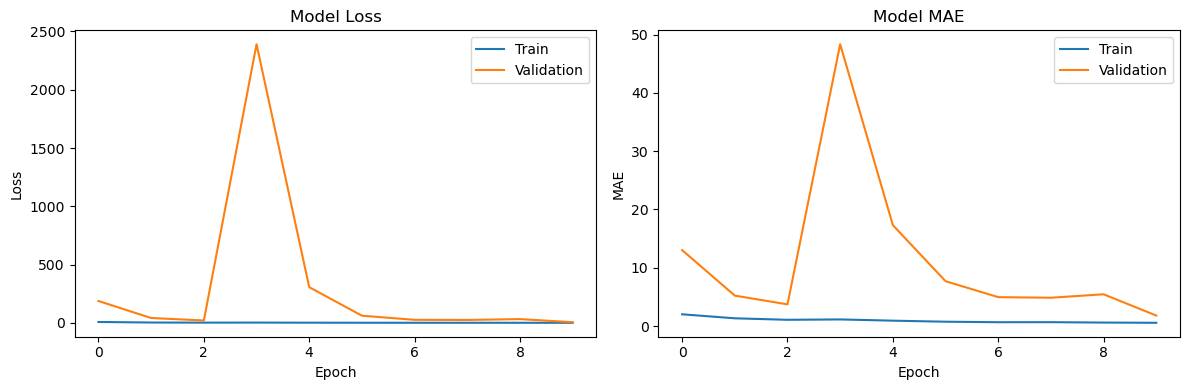

In [18]:
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()